<a href="https://colab.research.google.com/github/Amruthakap3/AML/blob/main/customer__satisfaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Satisfaction dataset analysis**

In [40]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import seaborn as sns
import sys
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# Load Customer Satisfaction Dataset and inspect

In [41]:
df = pd.read_csv('https://raw.githubusercontent.com/Amruthakap3/AML/main/Train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Amruthakap3/AML/main/Test.csv')
#df = pd.concat([df,df_test ])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [42]:
#To print missing values
print(df.isna().sum())

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64


In [43]:
df['Segmentation'].value_counts()

D    2268
A    1972
C    1970
B    1858
Name: Segmentation, dtype: int64

# Visualisations

In [44]:
segmentation_order =['A','B','C','D']
def countplot(x,hue,data,order,title,fig_size):
  fig,ax=plt.subplots(figsize=fig_size)
  sns.countplot(x=x,hue=hue,ax=ax,data=df,order=order,palette='cool')
  ax.set_title(title)
  plt.show()
  

**Customer Segmentation**

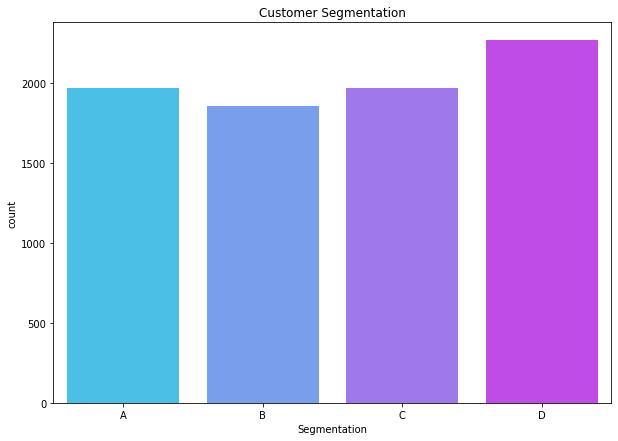

In [45]:
countplot ('Segmentation',None, df,segmentation_order,'Customer Segmentation',(10,7))

**Customer Segmentation based on Gender of the Customer**

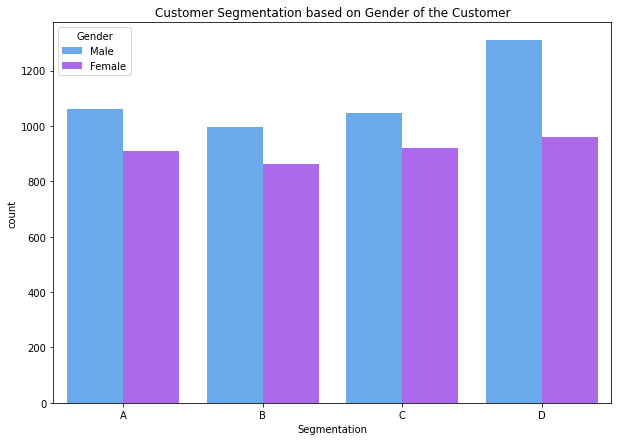

In [46]:
countplot ('Segmentation','Gender', df,segmentation_order,'Customer Segmentation based on Gender of the Customer',(10,7))

**Customer Segmentation Bbased on Spending Score**

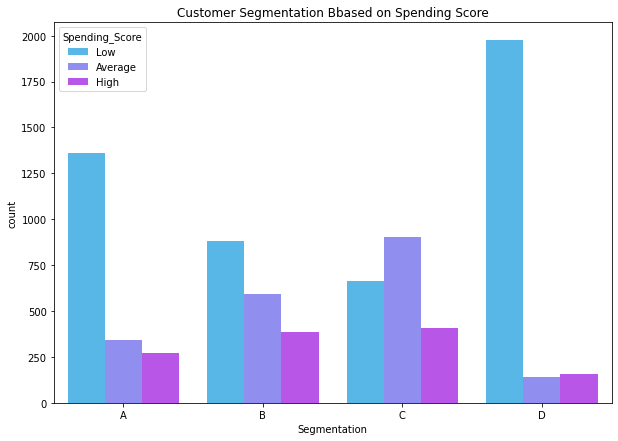

In [47]:
countplot ('Segmentation','Spending_Score', df,segmentation_order,'Customer Segmentation Bbased on Spending Score',(10,7))

**Customer Segmentation based on Marital Status**

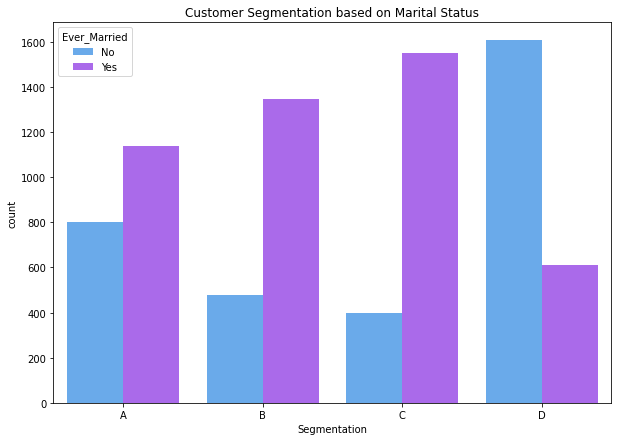

In [48]:
countplot ('Segmentation','Ever_Married', df,segmentation_order,'Customer Segmentation based on Marital Status',(10,7))

**Plot Correlation**

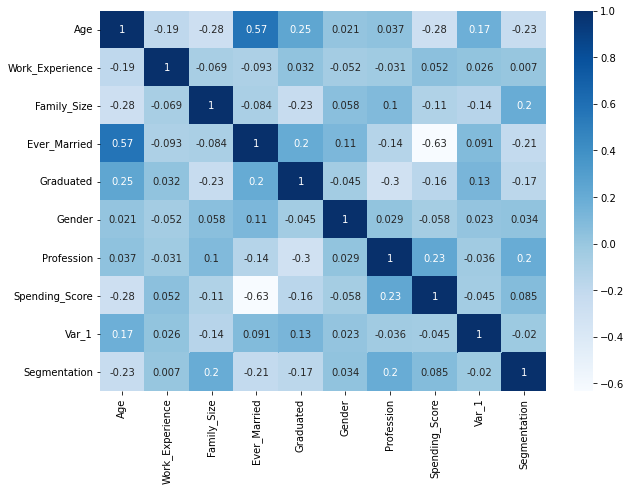

In [49]:
df_copy = df.copy()
df_copy.dropna(inplace = True)
df_copy.drop("ID", axis = 1, inplace=True)
cat=["Ever_Married","Graduated","Gender","Profession","Spending_Score","Var_1",'Segmentation']
for i in cat:
  le = LabelEncoder()
  labels= le.fit_transform(df_copy[i])
  df_copy.drop(i,axis=1,inplace=True)
  df_copy[i]=labels

fig,ax = plt.subplots(figsize=(10,7))
sns.heatmap( df_copy.corr(),annot = True,cmap="Blues",ax = ax)
plt.show()

There does not seem to be a strong relationship between the target and the variables. Age, Marital status,profession seems to effect segmentation slightly.

In [50]:
df2 = df.copy()
df2.dropna(inplace = True)
df2.drop("ID", axis = 1, inplace=True)
df2.head()


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
5,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C


# Cleanup and Scale Data

In [51]:
#cleanup and scale data
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler


# First create a pipeline for the categoric attributes

cat_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1']

cat_transformer = Pipeline(steps=[
    # strategies are mean, median, most_frequent, etc.
    ('imputer', SimpleImputer(strategy='most_frequent')),

    # In ordinal encoding, each unique category value is assigned an integer value.
    ('ordinal', OrdinalEncoder())
])

num_cols = ['Age', 'Work_Experience', 'Family_Size']

num_transformer = Pipeline(steps=[
    # Number of neighboring samples to use for K-nearest neighor imputation
    ('imputer', KNNImputer(n_neighbors=5)),

    # StandardScaler makes mean = 0 and scales the data to unit variance 
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])



In [52]:
#prepare data
np.random.seed(42)

# Try the scaled data set
X = df2[df2.columns[0:9]]


df2['Segmentation'] = df2['Segmentation'].map({'A':0, 'B':1, 'C':2, 'D':3})
y = df2['Segmentation']


# use the 80-20 rule for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)



# Pipelines For Various Classifier Models.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


num_folds = 10

########## A logistic regression model
lr_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(solver='saga', max_iter=100))])
lr_score = cross_val_score(lr_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with gini
gini_dt_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(criterion='gini'))])
gini_dt_score = cross_val_score(gini_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A decicion tree with entropy
entropy_dt_clf = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(criterion='entropy'))])
entropy_dt_score = cross_val_score(entropy_dt_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A random forest
rf_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
rf_clf_score = cross_val_score(rf_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## An RBF kernel classifier
rbf_svc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(kernel='rbf'))])
rbf_svc_clf_score = cross_val_score(rbf_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()


########## A poly kernel classifier
poly_svc_clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(kernel='poly'))])
poly_svc_clf_score = cross_val_score(poly_svc_clf, X, y, cv=num_folds, scoring="accuracy").mean()

**Model Comparison Plot**

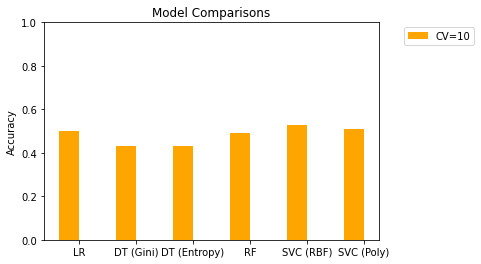

In [54]:
labels = ['LR', 'DT (Gini)', 'DT (Entropy)', 'RF', 'SVC (RBF)', 'SVC (Poly)']
training_scores = [lr_score, gini_dt_score, entropy_dt_score, rf_clf_score, rbf_svc_clf_score, poly_svc_clf_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='CV=10', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons')
plt.show()

**Decision Trees Visualization**

|--- Gender <= -0.58
|   |--- Gender <= -1.18
|   |   |--- Spending_Score <= 4.50
|   |   |   |--- truncated branch of depth 12
|   |   |--- Spending_Score >  4.50
|   |   |   |--- truncated branch of depth 12
|   |--- Gender >  -1.18
|   |   |--- Spending_Score <= 4.50
|   |   |   |--- truncated branch of depth 17
|   |   |--- Spending_Score >  4.50
|   |   |   |--- truncated branch of depth 20
|--- Gender >  -0.58
|   |--- Family_Size <= 1.50
|   |   |--- Spending_Score <= 0.50
|   |   |   |--- truncated branch of depth 23
|   |   |--- Spending_Score >  0.50
|   |   |   |--- truncated branch of depth 22
|   |--- Family_Size >  1.50
|   |   |--- Spending_Score <= 1.50
|   |   |   |--- truncated branch of depth 21
|   |   |--- Spending_Score >  1.50
|   |   |   |--- truncated branch of depth 21



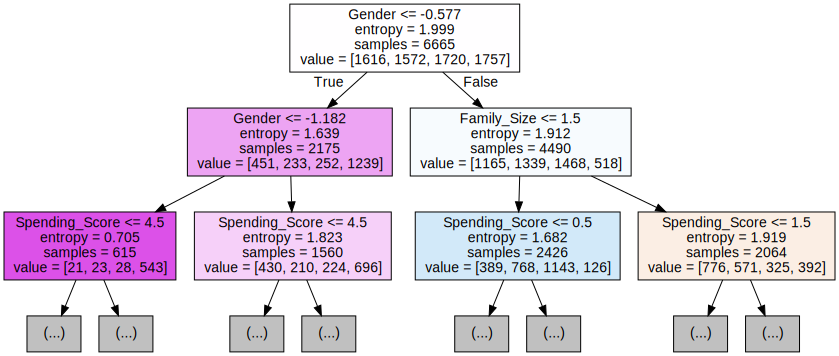

In [55]:
# Convert the decision tree model to text and graph

from matplotlib import pyplot
from sklearn.tree import export_text, export_graphviz
import graphviz

# we need to refit the DT model that is part of a composite pipe before exporting it as text
entropy_dt_clf['classifier'].fit(preprocessor.fit_transform(X), y)

feature_names = ['Gender', 'Ever_Married'	,'Age'	, 'Graduated', 'Profession'	,'Work_Experience'	,'Spending_Score', 'Family_Size'	,'Var_1']

# display the induced decision tree as a series of logical rules
text_representation = export_text(entropy_dt_clf['classifier'],
                                  feature_names=feature_names,
                                  max_depth=2)
print(text_representation)


# draw the induced decision tree
dot_data = export_graphviz(entropy_dt_clf['classifier'],
                                  max_depth=2,
                                  feature_names=feature_names,
                                  filled=True)

graph = graphviz.Source(dot_data, format="png") 
graph

**Feature Importances**

Feature: Gender, Score: 0.37144
Feature: Ever_Married, Score: 0.15995
Feature: Age, Score: 0.10009
Feature: Graduated, Score: 0.04501
Feature: Profession, Score: 0.02057
Feature: Work_Experience, Score: 0.04012
Feature: Spending_Score, Score: 0.12422
Feature: Family_Size, Score: 0.06218
Feature: Var_1, Score: 0.07641


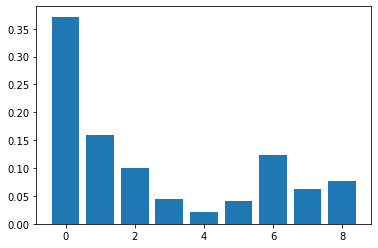

In [56]:
# get feature importances from the model
importance = entropy_dt_clf['classifier'].feature_importances_

# summarize feature importances
for i,v in enumerate(importance):
	print('Feature: %0s, Score: %.5f' % (feature_names[i],v))
 
# plot feature importances
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Hyperparemeter Optimization
Find optimum values of hyperparameters using GridSearchCV

In [57]:
# Use GridSearchCV to find optimum hyperparameter values for the LogisticRegression regresssion
# create a dictionary of all values we want to test
C = np.logspace(-4, 4, 10)
penalty = ['l1', 'l2']
param_grid_1 = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
   
# use gridsearch to test all values
grid_search_1 = GridSearchCV(lr_clf['classifier'], param_grid_1, cv=20, scoring='accuracy', verbose=-1)
    
# fit the model 
grid_search_1.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search_1.best_score_))
print("The best LogisticRegression model hyperparameters:", grid_search_1.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

The best achieved accuracy after hyperparameter optimization: 0.50 

The best LogisticRegression model hyperparameters: {'C': 1.0, 'penalty': 'l1'}


In [58]:
# Use GridSearchCV to find optimum hyperparameter values for the A decicion tree with gini

# create a dictionary of all values we want to test
param_grid2 = { 'criterion':['gini','entropy'],    # impurity criterion
                'max_depth': np.arange(3, 10)}      # tree depth 
   
# use gridsearch to test all values
grid_search2 = GridSearchCV(gini_dt_clf['classifier'],  param_grid2, cv=10)
    
# fit the model 
grid_search2.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search2.best_score_))
print("The best decicion tree with gini model hyperparameters:", grid_search2.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.53 

The best decicion tree with gini model hyperparameters: {'criterion': 'entropy', 'max_depth': 5}


In [59]:
# Use GridSearchCV to find optimum hyperparameter values for the A decicion tree with entropy

# create a dictionary of all values we want to test
param_grid3 = { 'criterion':['gini','entropy'],    # impurity criterion
                'max_depth': np.arange(3, 10)}      # tree depth 
   
# use gridsearch to test all values
grid_search3 = GridSearchCV(entropy_dt_clf['classifier'],  param_grid3, cv=10)
    
# fit the model 
grid_search3.fit(preprocessor.fit_transform(X_train), y_train)

print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search3.best_score_))
print("The best decicion tree with entropy model hyperparameters:", grid_search3.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.53 

The best decicion tree with entropy model hyperparameters: {'criterion': 'entropy', 'max_depth': 5}


In [60]:
# Use GridSearchCV to find optimum hyperparameter values for the Randomforest
# create a dictionary of all values we want to test
param_grid4 = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
   
    
# use gridsearch to test all values
grid_search4 = GridSearchCV(rf_clf['classifier'], param_grid4, cv=2, verbose=0, scoring='accuracy')
    
# fit the model 
grid_search4.fit(preprocessor.fit_transform(X_train), y_train)

   
print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search4.best_score_))

print("The best Randomforest model hyperparameters:", grid_search4.best_params_)


The best achieved accuracy after hyperparameter optimization: 0.54 

The best Randomforest model hyperparameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}


In [61]:
# Use GridSearchCV to find optimum hyperparameter values for the SVC poly model
# Run the job paralal by passing n_jobs=-1
if __name__=='__main__':
    
    # create a dictionary of all values we want to test
    param_grid5 = {'kernel':['poly'], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
                  'gamma':['scale','auto'],
                  'degree': np.arange(2,4),  # polynomial degree
                  'C': np.arange(1,5)}       # Regularization parameter
      
        
    # use gridsearch to test all values
    grid_search5 = GridSearchCV(poly_svc_clf['classifier'], 
                              param_grid5, 
                              cv=3, scoring='accuracy', n_jobs=-1, verbose=10)
        
    # fit the model 
    grid_search5.fit(preprocessor.fit_transform(X_train), y_train)

      
    print("The best achieved accuracy after hyperparameter optimization: %.2f\n" % grid_search5.best_score_)
    print("The best SVC poly model hyperparameters:", grid_search5.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best achieved accuracy after hyperparameter optimization: 0.52

The best SVC poly model hyperparameters: {'C': 3, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}


In [62]:
# Use GridSearchCV to find optimum hyperparameter values for the RBF kernel classifier
# create a dictionary of all values we want to test

param_grid6 = {"C":3. ** np.arange(-3, 3), "gamma": 5. ** np.arange(-5, 2), 'kernel': ['rbf', 'sigmoid']}
   
# use gridsearch to test all values
grid_search6 = GridSearchCV(rbf_svc_clf['classifier'], param_grid6, cv=2, scoring='accuracy', verbose=1)
    
# fit the model 
grid_search6.fit(preprocessor.fit_transform(X_train), y_train)

print("The best achieved accuracy after hyperparameter optimization: %.2f \n" % (grid_search6.best_score_))
print("The best RBF kernel  model hyperparameters:", grid_search6.best_params_)

Fitting 2 folds for each of 84 candidates, totalling 168 fits
The best achieved accuracy after hyperparameter optimization: 0.52 

The best RBF kernel  model hyperparameters: {'C': 3.0, 'gamma': 0.04, 'kernel': 'rbf'}


**Hyperparamater Optimization Comparison (Before optimization Vs After optimization)**

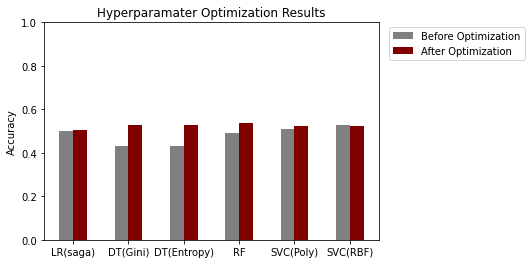

In [63]:
# graph results of grid search for the two models

labels = ['LR(saga)','DT(Gini)','DT(Entropy)','RF','SVC(Poly)', 'SVC(RBF)']
before_optimization_scores = [lr_score, gini_dt_score, entropy_dt_score, rf_clf_score, poly_svc_clf_score, rbf_svc_clf_score]
after_optimization_scores = [grid_search_1.best_score_, grid_search2.best_score_, grid_search3.best_score_, grid_search4.best_score_, grid_search5.best_score_, grid_search6.best_score_]

x = np.arange(len(labels))  # the label locations
width = 0.25                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_optimization_scores, width, label='Before Optimization', color='gray')
rects2 = ax.bar(x + width/2, after_optimization_scores, width, label='After Optimization', color='maroon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1.0)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.45, 1.0), loc='upper right')

plt.title('Hyperparamater Optimization Results')
plt.show()


We loaded the  Customer Satisfaction dataset and analyzed the data in multiple ways like plotting, correlation to identify the relationship with the decision variable, etc. We followed the following steps  

1.   pipelines to impute and prepare data
2.   pipelines to perform classification
3.   Encode the labels for multi-classification 
3.   converting decision trees to text and graph
4.   performing grid search to optimize a few hyperparameters


The obtained results show that the average accuracy measure for all models was around 48% to 55%. 


GridSearchCV was not performed exhaustively although the last two experiments and the plotted graph show that modest improvements can be made by just optimizing a few hyperparameters.